In [1]:
################################################################################################################################
#
# LSTM - JANSEN - LN - MONTHLY
#
################################################################################################################################

#-------------------------------------------------------------------------------------------------------------------------------
# 
#-------------------------------------------------------------------------------------------------------------------------------

#===============================================================================================================================
# ENVIRONMENT: LIBRARIES, SETTINGS
#===============================================================================================================================
#pip install pandas-datareader

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn
import sklearn.preprocessing
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation
from tensorflow import keras

In [2]:
#===============================================================================================================================
# ENVIRONMENT: HARDWARE
#===============================================================================================================================
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
#===============================================================================================================================
# ENVIRONMENT: CONFIG
#===============================================================================================================================
sns.set_style('whitegrid')
np.random.seed(42)

In [4]:
#===============================================================================================================================
# DATA: INPUT/OUTPUT
#===============================================================================================================================
input_path = Path('Data', 'Input')
results_path = Path('Data\Output', 'LSTM-Jansen-Ln-Montlhy')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [5]:
#===============================================================================================================================
# DATA: SETTINGS
#===============================================================================================================================
seriesId='IBOV-monthly'
#ESCALA = 'log'  #'minmax' 
#EPOCAS = 100
#LOTE = 12
#NEURONS = 32
window_size=6

#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
df = pd.read_csv(seriesId+'.csv')
df['Date']= pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.set_index('Date', inplace=True)
df

,Close
Date,
2000-01-28,16734.39
2000-02-29,17660.20
2000-03-31,17820.37
2000-04-28,15537.60
2000-05-31,14956.61
...,...
2023-08-31,115741.81
2023-09-29,116565.17
2023-10-31,113143.67


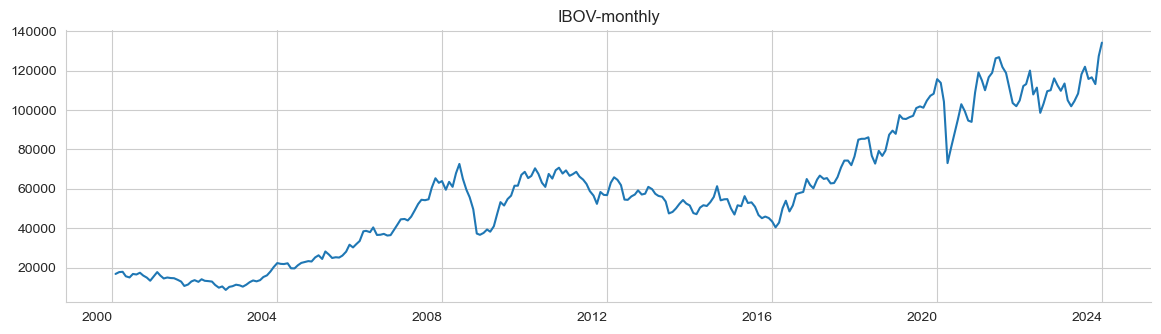

In [6]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
ax = df.plot(title=seriesId, legend=False, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
#===============================================================================================================================
# DATA: LOG - SCALE
#===============================================================================================================================
df_scaled = df.copy()
df_scaled['Close'] = np.log(df_scaled['Close'])

df_scaled.describe()

,Close
count,288.000000
mean,10.771096
std,0.693493
min,9.062135
25%,10.477774
50%,10.933172
75%,11.215829
max,11.806977


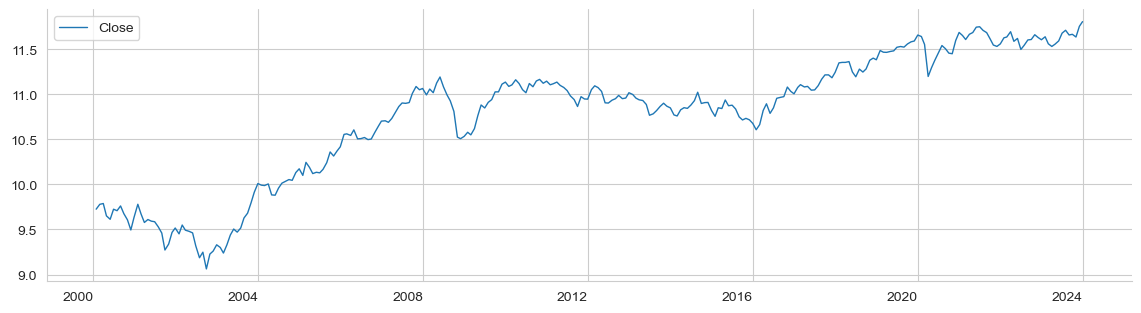

In [8]:
#===============================================================================================================================
# DATA: LOG - PLOT
#===============================================================================================================================
ax = df_scaled.plot(lw=1, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [9]:
#===============================================================================================================================
# DATA: PREP - RECURRENT SEQUENCES - FUNCTION
#===============================================================================================================================
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    #y = data[window_size-1:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    #X = np.hstack(tuple([data[i: n-j+1, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [10]:
#===============================================================================================================================
# DATA: PREP - SEQUENCES
#===============================================================================================================================
X, y = create_univariate_rnn_data(df_scaled, window_size=window_size)
X


,0,1,2,3,4,5
Date,,,,,,
2000-07-31,9.725221,9.779069,9.788097,9.651018,9.612909,9.724836
2000-08-31,9.779069,9.788097,9.651018,9.612909,9.724836,9.708360
2000-09-29,9.788097,9.651018,9.612909,9.724836,9.708360,9.761158
2000-10-31,9.651018,9.612909,9.724836,9.708360,9.761158,9.675858
2000-11-30,9.612909,9.724836,9.708360,9.761158,9.675858,9.606915
...,...,...,...,...,...,...
2023-08-31,11.561067,11.531573,11.556288,11.592984,11.679177,11.711309
2023-09-29,11.531573,11.556288,11.592984,11.679177,11.711309,11.659117
2023-10-31,11.556288,11.592984,11.679177,11.711309,11.659117,11.666206


In [11]:
#===============================================================================================================================
# DATA: PREP - SPLIT
#===============================================================================================================================
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']

# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((270, 6, 1), (270, 1), (12, 6, 1), (12, 1))

In [12]:
#===============================================================================================================================
# DATA: PREP - OBS, WINDOWS, FEATURES
#===============================================================================================================================
n_obs, window_size, n_features = X_train.shape
n_obs, window_size, n_features

(270, 6, 1)

In [13]:
#===============================================================================================================================
# MODEL: LSTM
#===============================================================================================================================
rnn = Sequential([
    LSTM(units=10, input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])

rnn.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM (LSTM)                 (None, 10)                480       
                                                                 
 Output (Dense)              (None, 1)                 11        
                                                                 
Total params: 491 (1.92 KB)
Trainable params: 491 (1.92 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
#===============================================================================================================================
# MODEL: CONFIG
#===============================================================================================================================
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, weight_decay=0.0)

rnn.compile(loss='mean_squared_error', optimizer=optimizer)

rnn_path = (results_path / 'Montlhy-Ln-rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path, verbose=1, monitor='val_loss', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [15]:
#===============================================================================================================================
# MODEL: TRAIN
#===============================================================================================================================
lstm_training = rnn.fit(X_train, y_train, epochs=150, batch_size=12, shuffle=True, 
                        validation_data=(X_test, y_test), 
                        callbacks=[early_stopping, checkpointer],verbose=1)

Epoch 1/150

16/23 [===================>..........] - ETA: 0s - loss: 101.2544 
Epoch 1: val_loss improved from inf to 115.51760, saving model to Data/Output/LSTM-Jansen-Ln-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 6s 62ms/step - loss: 100.5597 - val_loss: 115.5176
Epoch 2/150
17/23 [=====================>........] - ETA: 0s - loss: 96.5682
Epoch 2: val_loss improved from 115.51760 to 110.11105, saving model to Data/Output/LSTM-Jansen-Ln-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 0s 10ms/step - loss: 95.3058 - val_loss: 110.1111
Epoch 3/150
16/23 [===================>..........] - ETA: 0s - loss: 91.6034
Epoch 3: val_loss improved from 110.11105 to 104.58002, saving model to Data/Output/LSTM-Jansen-Ln-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 0s 10ms/step - loss: 90.2622 - val_loss: 104.5800
Epoch 4/150
20/23 [=========================>....] - ETA: 0s - loss: 85.2997
Epoch 4: val_loss improved from 104.58002 to 9

23/23 [==============================] - 0s 10ms/step - loss: 5.1693 - val_loss: 8.6325
Epoch 29/150
18/23 [======================>.......] - ETA: 0s - loss: 4.3175
Epoch 29: val_loss improved from 8.63251 to 7.24584, saving model to Data/Output/LSTM-Jansen-Ln-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 0s 10ms/step - loss: 4.1630 - val_loss: 7.2458
Epoch 30/150
19/23 [=======================>......] - ETA: 0s - loss: 3.3732
Epoch 30: val_loss improved from 7.24584 to 6.01779, saving model to Data/Output/LSTM-Jansen-Ln-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 0s 11ms/step - loss: 3.2933 - val_loss: 6.0178
Epoch 31/150
19/23 [=======================>......] - ETA: 0s - loss: 2.6575
Epoch 31: val_loss improved from 6.01779 to 4.91435, saving model to Data/Output/LSTM-Jansen-Ln-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 0s 11ms/step - loss: 2.5511 - val_loss: 4.9143
Epoch 32/150
18/23 [======================>.......]

Epoch 62/150
17/23 [=====================>........] - ETA: 0s - loss: 0.4680
Epoch 62: val_loss improved from 0.76254 to 0.75888, saving model to Data/Output/LSTM-Jansen-Ln-Montlhy\Montlhy-Ln-rnn.h5
23/23 [==============================] - 0s 11ms/step - loss: 0.4508 - val_loss: 0.7589
Epoch 63/150
19/23 [=======================>......] - ETA: 0s - loss: 0.4556
Epoch 63: val_loss did not improve from 0.75888
23/23 [==============================] - 0s 8ms/step - loss: 0.4520 - val_loss: 0.7761
Epoch 64/150
17/23 [=====================>........] - ETA: 0s - loss: 0.4715
Epoch 64: val_loss did not improve from 0.75888
23/23 [==============================] - 0s 9ms/step - loss: 0.4513 - val_loss: 0.8211
Epoch 65/150
17/23 [=====================>........] - ETA: 0s - loss: 0.4427
Epoch 65: val_loss did not improve from 0.75888
23/23 [==============================] - 0s 10ms/step - loss: 0.4514 - val_loss: 0.8132
Epoch 66/150
17/23 [=====================>........] - ETA: 0s - loss: 0.4606

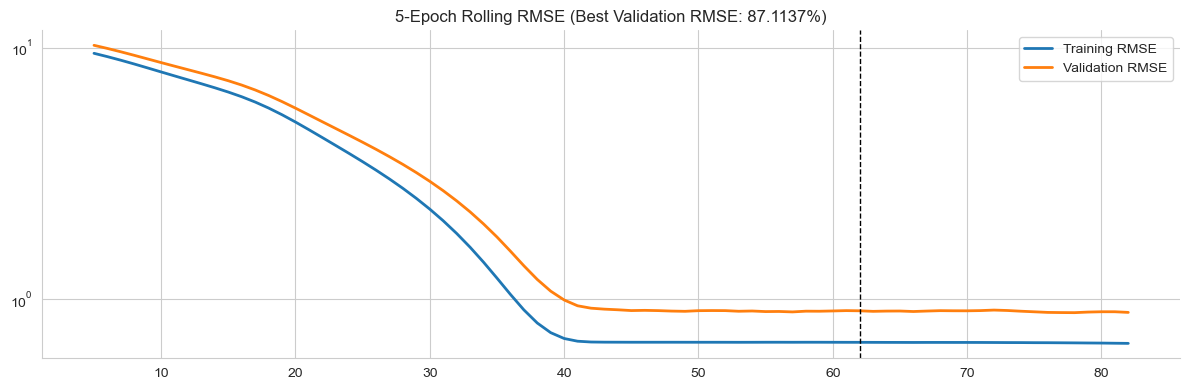

In [16]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

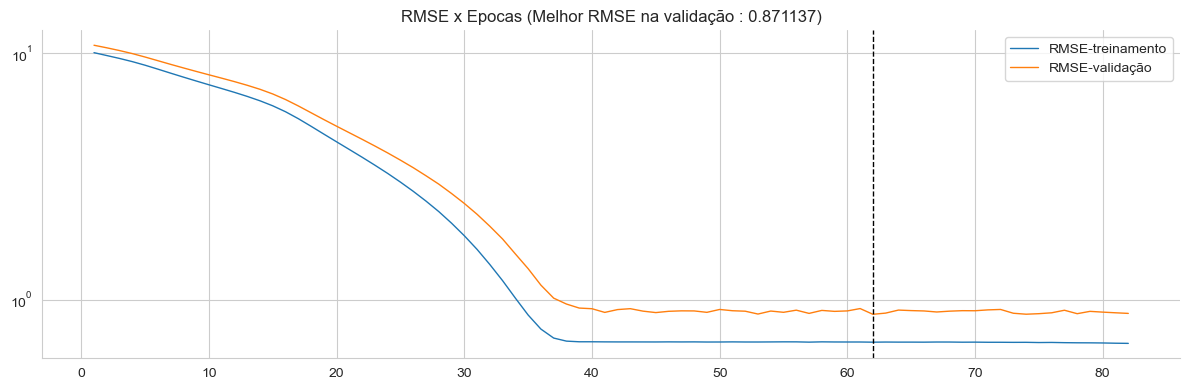

In [17]:
#===============================================================================================================================
# RESULTS - PERFORMANCE vs EPOCHS - TRAIN, VALIDATION
#===============================================================================================================================
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'RMSE x Epocas (Melhor RMSE na validação : {best_rmse:.6})'
loss_history.columns=['RMSE-treinamento', 'RMSE-validação']
loss_history.rolling(1).mean().plot(logy=True, lw=1, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_error', dpi=300);

In [18]:
#===============================================================================================================================
# RESULTS - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 0.1056 | Test RMSE: 0.1074
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 0.6715 | Test RMSE: 0.8711


In [19]:
#===============================================================================================================================
# RESULTS - FORECAST - TRAIN, TEST
#===============================================================================================================================
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

1/1 [==============================] - 0s 70ms/step


In [20]:
#===============================================================================================================================
# RESULTS - SPEARMAN IC - TRAIN, TEST
#===============================================================================================================================
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.6f} | Test IC: {test_ic:.4f}')
#-------------------------------------------------------------------------------------------------------------------------------
# Train IC: 0.978179 | Test IC: 0.5664
#-------------------------------------------------------------------------------------------------------------------------------

Train IC: 0.987893 | Test IC: 0.6224


In [21]:
#===============================================================================================================================
# RESULTS - FORECAST - SCALED - TEST 
#===============================================================================================================================
np.savetxt('Data/Output/LSTM-Jansen-Montlhy-Ln-Scaled-Train.txt', train_predict_scaled, delimiter=';')
np.savetxt('Data/Output/LSTM-Jansen-Montlhy-Ln-Scaled-Test.txt ', test_predict_scaled , delimiter=';')
test_predict_scaled[:,0]

array([10.781968 , 10.7820015, 10.781922 , 10.781893 , 10.781918 ,
       10.781955 , 10.782042 , 10.782072 , 10.782021 , 10.782028 ,
       10.781998 , 10.782115 ], dtype=float32)

In [22]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - PRED - TRAIN, TEST
#===============================================================================================================================
train_predict = pd.Series(np.exp(train_predict_scaled[:,0]), index=y_train.index)
test_predict  = pd.Series(np.exp(test_predict_scaled[:,0]), index=y_test.index)

test_predict

Date
2023-01-31    48144.781250
2023-02-28    48146.394531
2023-03-31    48142.578125
2023-04-28    48141.160156
2023-05-31    48142.347656
2023-06-30    48144.140625
2023-07-31    48148.320312
2023-08-31    48149.789062
2023-09-29    48147.312500
2023-10-31    48147.675781
2023-11-30    48146.207031
2023-12-28    48151.855469
dtype: float32

In [23]:
#===============================================================================================================================
# RESULTS - PRICE - RECOVER - TARGET - TRAIN, TEST
#===============================================================================================================================
y_train_rescaled = np.exp(y_train['Close'])
y_test_rescaled  = np.exp(y_test['Close'])

y_test_rescaled

Date
2023-01-31    113430.54
2023-02-28    104931.93
2023-03-31    101882.20
2023-04-28    104431.63
2023-05-31    108335.07
2023-06-30    118087.00
2023-07-31    121942.98
2023-08-31    115741.81
2023-09-29    116565.17
2023-10-31    113143.67
2023-11-30    127331.12
2023-12-28    134185.24
Name: Close, dtype: float64

In [24]:
#===============================================================================================================================
# RESULTS - PRICE - PERFORMANCE - TRAIN, TEST
#===============================================================================================================================
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

#-------------------------------------------------------------------------------------------------------------------------------
# Train RMSE: 6111.18 | Test RMSE: 12355.51
#-------------------------------------------------------------------------------------------------------------------------------

Train RMSE: 31396.47 | Test RMSE: 67484.79


In [25]:
#===============================================================================================================================
# RESULTS - PRICE - STORE - TRAIN, TEST
#===============================================================================================================================
df['Train Predictions'] = train_predict
df['Test Predictions'] = test_predict

temp = pd.concat([train_predict.to_frame('predictions').assign(data='Train'), test_predict.to_frame('predictions').assign(data='Test')])
df['predictions'] = temp['predictions']
df['data']        = temp[ 'data']

df['2022-12-29':]

,Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2022-12-29,109734.60,48145.976562,NaN,48145.976562,Train
2023-01-31,113430.54,NaN,48144.781250,48144.781250,Test
2023-02-28,104931.93,NaN,48146.394531,48146.394531,Test
2023-03-31,101882.20,NaN,48142.578125,48142.578125,Test
2023-04-28,104431.63,NaN,48141.160156,48141.160156,Test
2023-05-31,108335.07,NaN,48142.347656,48142.347656,Test
2023-06-30,118087.00,NaN,48144.140625,48144.140625,Test
2023-07-31,121942.98,NaN,48148.320312,48148.320312,Test
2023-08-31,115741.81,NaN,48149.789062,48149.789062,Test


In [26]:
#===============================================================================================================================
# RESULTS - PRICE - EXPORT
#===============================================================================================================================
df.to_excel('Data/Output/LSTM-Jansen-Montlhy-Ln.xlsx')

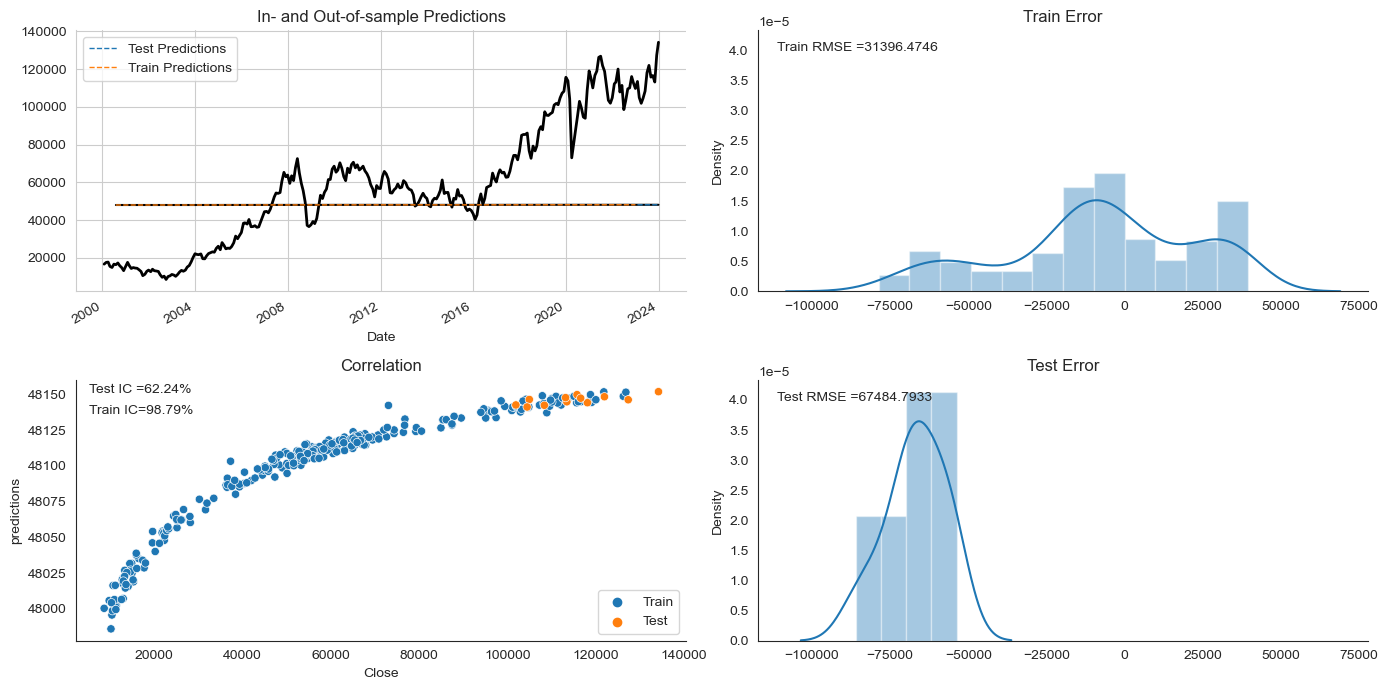

In [27]:
#===============================================================================================================================
# RESULTS - PRICE - PLOT
#===============================================================================================================================
fig=plt.figure(figsize=(14,7))

ax1 = plt.subplot(221)
df.loc['2000':, 'Close'].plot(lw=2, ax=ax1, c='k')
df.loc['2000':, 'predictions'].plot(lw=1.5, ax=ax1, c='k')
df.loc['2000':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='Close', y='predictions', data=df, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_regression', dpi=300);
